In [ ]:
# !pip install git+https://github.com/NVIDIA-Merlin/models.git

# Environment Setup

Push a Nvidia repo to your artifact repository - (create a new repo if not available)

### Further instructions on how to build a Merlin container can be found [here](https://github.com/jswortz/merlin-gcp)

Guide
1. In an notebook instance run from a terminal `git clone https://github.com/jswortz/merlin-gcp`
2. Run the notebook - this will build a merlin tensorflow image. You can change the base images from NVidia if you choose - this was tested from the version in the repo
3. This will build a container image and save it to artifact registry repository. You may need to enable the artifact repository service
4. Create a new custom workbench by clicking "New Notebook" > "Customize"

<img src="img/custom_workbench.png" width="500"/>

5. To get to the screen for artifact repository. First select "Advanced" then name, select region, then go to "Environment"

<img src="img/workbench-environment.png" width="500"/>

6. Select the your repo and respective image

<img src="img/image.png" width="500"/>

7. Finally, if you already followed the instructions in notebook 02 setup - make sure the new workbench network is in the VPC peered network used for matching engine

# Training with Merlin

## Spotify example

Our goal is to enable the architecture below with Vertex AI and the Merlin Models framework

![](img/arch.png)

## Goals

The goal of this notebook is to create a simple two tower model with Nvtabular and Merlin Models

1. Export data to Parquet for use in Nvtabular
2. Create a NVtabular workflow and fit it to the data
3. Save the fitted workflow to GCS (contains all dictionary lookups)
4. Transform the data into GPU-optimized features from the NVtabular workflow and save to gcs
5. Load the data again as a Merlin dataset using the workflow
6. Create a two tower model in a few lines of code
7. Train a two tower model
8. Save the model (for deployment in notebook 03)
9. Export the embeddings and save to gcs (for deployment to matching engine)

*Based heavily on [this](https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb) NVIDIA resource


Data is loaded from BQ - to parquet using the job configuration below


Info on the data

* track_uri_seed counts: 2249561
* artist_uri_seed counts: 294110
* album_uri_seed counts: 730377

# Export Data From BigQuery to Parquet on GCS

In [1]:
PROJECT = 'wortz-project-352116'  # <--- TODO: CHANGE THIS
LOCATION = 'us-central1'
# path = 'gs://two-tower-models' #TODO change to your model directory
BUCKET = 'gs://spotify-jsw-mpd-2023'
DATASET_ID = 'spotify_e2e_test'
TABLE = 'train_flatten_last_5'
TABLE_VALIDATION = 'train_flatten_valid_last_5'


import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

from google.cloud import bigquery
client = bigquery.Client()



def export_bq_to_parquet(PROJECT, DATASET_ID, TABLE, LOCATION, prefix):
    destination_uri = f"{BUCKET}/{prefix}_data_parquet/*.snappy.parquet"
    dataset_ref = bigquery.DatasetReference(PROJECT, DATASET_ID)
    table_ref = dataset_ref.table(TABLE)
    job_config = bigquery.job.ExtractJobConfig()
    job_config.destination_format = bigquery.DestinationFormat.PARQUET
    extract_job = client.extract_table(
        table_ref,
        destination_uri,
        job_config=job_config,
        # Location must match that of the source table.
        location='US',
    )  # API request
    return(extract_job.result())  # Waits for job to complete.

#### Export the data from Bigquery to Parquet

*Run only once* Uncomment to run

In [5]:
# # training
# export_bq_to_parquet(PROJECT, DATASET_ID, TABLE, LOCATION, prefix='train')

# # # validation
# export_bq_to_parquet(PROJECT, DATASET_ID, TABLE_VALIDATION, LOCATION, prefix='valid')

# Create a NVTabular Workflow To Preprocess The Data

In [4]:
from time import time
import pandas as pd
# disable INFO and DEBUG logging everywhere
import logging
import time
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
import fsspec
import numpy as np

import nvtabular as nvt
from merlin.io.shuffle import Shuffle
from nvtabular.ops import (
    Categorify,
    TagAsUserID,
    TagAsItemID,
    TagAsItemFeatures,
    TagAsUserFeatures,
    AddMetadata,
    ListSlice
)
import nvtabular.ops as ops
from nvtabular.utils import device_mem_size

from merlin.schema.tags import Tags
# import merlin.models.tf as mm
from merlin.io.dataset import Dataset
import tensorflow as tf


logging.disable(logging.WARNING)


# for running this example on CPU, comment out the line below


2023-05-25 19:43:32.861358: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 19:43:33.000271: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/torch.py:43: UserWarning: PyTorch dtype mappings did not load successfully due to an error: No module named 'torch'
  warn(f"PyTorch dtype mappings did not load successfully due to an error: {exc.msg}")


### Create NVTabular Dataset
This will be our pre-processor to hash strings and other preprocessing

In [3]:
train = nvt.Dataset(f"{BUCKET}/train_data_parquet/*.snappy.parquet")
valid = nvt.Dataset(f"{BUCKET}/valid_data_parquet/*.snappy.parquet")

#### Define the NVTabular preprocessing graph

Nvtabular takes a tabular dataset and transforms the data into new Parquet files optimized for training. This is equivalent to running a string lookup in tensorflow, and has similar functionality as adpat when a workflow is used

The graph is defined as a set of nodes and a node is defined as follows:

```
NODE_NAME = LIST_OF_FEATURE_NAMES >> nvt.ops.* >> [NEXT_STEP] >> Tag
```

Nvt has many ops - one of the most notable is `Categorify` as it is flexible and converts high cardinality text features to indicies

Tags are used as a means to label the schema in the metadata and serves as a label for merlin models to interpret for consumption (e.g. which features belong to the query tower and candidate tower have different tags). You will see the tags in the schema in examples below

### Define a workflow
This is an easy step by adding all nodes that need to run in parallel. A graphviz visualization of the graph is available below

### Before we transform the data, let's look at an original record
This loads the data into a dask pandas dataframe. `.to_ddf()` converts the dataset into a dask df

In [14]:
# =============================================
# featutres
# =============================================
item_id = ["track_uri_can"] >> Categorify(dtype="int32") >> TagAsItemID() 
playlist_id = ["pid"] >> Categorify(dtype="int32") >> TagAsUserID() 


item_features_cat = [
    'artist_name_can',
    'track_name_can',
    'artist_genres_can',
]

item_features_cont = [
    'duration_ms_can',
    'track_pop_can',
    'artist_pop_can',
    'artist_followers_can',
]

playlist_features_cat = [
    'pl_name_src',
    'pl_collaborative_src',
]

playlist_features_cont = [
    'pl_duration_ms_new',
    'num_pl_songs_new',
    'num_pl_artists_new',
    'num_pl_albums_new',
]

seq_feats_cat = [
    'artist_name_pl',
    'track_uri_pl',
    'track_name_pl',
    'album_name_pl',
    'artist_genres_pl',
]

CAT = playlist_features_cat + item_features_cat
CONT = item_features_cont + playlist_features_cont

# item_feature_cat_node = item_features_cat >> nvt.ops.FillMissing()>> Categorify(dtype="int32") >> TagAsItemFeatures()

# item_feature_cont_node =  item_features_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsItemFeatures()

# playlist_feature_cat_node = playlist_features_cat >> nvt.ops.FillMissing() >> Categorify(dtype="int32") >> TagAsUserFeatures() 

# playlist_feature_cont_node = playlist_features_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsUserFeatures()

# playlist_feature_cat_seq_node = seq_feats_cat >> nvt.ops.FillMissing() >> Categorify(dtype="int32") >> TagAsUserFeatures() 

# =============================================
# create cluster
# =============================================
# def create_cluster(
#     n_workers,
#     device_limit_frac,
#     device_pool_frac,
#     memory_limit
# ):
#     """Create a Dask cluster to apply the transformations steps to the Dataset."""
#     device_size = device_mem_size()
#     device_limit = int(device_limit_frac * device_size)
#     device_pool_size = int(device_pool_frac * device_size)
#     rmm_pool_size = (device_pool_size // 256) * 256

#     cluster = LocalCUDACluster(
#         n_workers=n_workers,
#         device_memory_limit=device_limit,
#         rmm_pool_size=rmm_pool_size,
#         memory_limit=memory_limit
#     )

#     return Client(cluster)

# =============================================
#            Create & Save dataset
# =============================================

def create_parquet_nvt_dataset(
    # data_path,
    frac_size,
    file_pattern=None,
):
    """Create a nvt.Dataset definition for the parquet files."""
    
    #DATA_PATH = f"gs://{bucket_name}/{data_prefix}/{file_pattern}" #0000000000**.snappy.parquet"

        # os.path.join(data_path, '*.parquet')
    # )

#     if not file_list:
#         raise FileNotFoundError('Parquet file(s) not found')

#     file_list = [os.path.join('gs://', i) for i in file_list]

    # return nvt.Dataset(f"{bucket_name}/{data_prefix}/0000000000**.snappy.parquet", part_mem_fraction=frac_size)
    
    file_list = os.path.join(file_pattern, "train", "*.snappy.parquet")
    
    print(file_list)
    return nvt.Dataset(
        file_list,
        engine='parquet',
        part_mem_fraction=frac_size
  )

def save_dataset(
    dataset,
    output_path,
    output_files,
    # categorical_cols,
    # continuous_cols,
    shuffle=None,
):
    """Save dataset to parquet files to path."""
    categorical_cols=CAT
    continuous_cols=CONT

    dict_dtypes = {}
    for col in categorical_cols:
        dict_dtypes[col] = np.int32

    for col in continuous_cols:
        dict_dtypes[col] = np.float64

    dataset.to_parquet(
        output_path=output_path,
        shuffle=shuffle,
        output_files=output_files,
        dtypes=dict_dtypes,
        cats=categorical_cols,
        conts=continuous_cols,
    )

# =============================================
#            Workflow
# =============================================
def create_nvt_workflow():
    '''
    Create a nvt.Workflow definition with transformation all the steps
    '''
    item_id = ["track_uri_can"] >> Categorify(dtype="int32") >> TagAsItemID() 
    playlist_id = ["pid"] >> Categorify(dtype="int32") >> TagAsUserID() 


    item_features_cat = ['artist_name_can',
            'track_name_can',
            'artist_genres_can',
        ]

    item_features_cont = [
            'duration_ms_can',
            'track_pop_can',
            'artist_pop_can',
            'artist_followers_can',
        ]

    playlist_features_cat = [
            'pl_name_src',
            'pl_collaborative_src',
        ]

    playlist_features_cont = [
            'pl_duration_ms_new',
            'num_pl_songs_new',
            'num_pl_artists_new',
            'num_pl_albums_new',
        ]

    seq_feats_cat = [
            'artist_name_pl',
            'track_uri_pl',
            'track_name_pl',
            'album_name_pl',
            'artist_genres_pl',
        ]

    CAT = playlist_features_cat + item_features_cat
    CONT = item_features_cont + playlist_features_cont

    item_feature_cat_node = item_features_cat >> Categorify(dtype="int32") >> TagAsItemFeatures()

    item_feature_cont_node =  (
        item_features_cont 
        >> nvt.ops.FillMedian() 
        >>  nvt.ops.Normalize() 
        >> nvt.ops.LambdaOp(lambda col: col.astype("float32"))
        >> TagAsItemFeatures()
    )

    playlist_feature_cat_node = playlist_features_cat >> Categorify(dtype="int32") >> TagAsUserFeatures() 

    playlist_feature_cont_node = (
        playlist_features_cont 
        >> nvt.ops.FillMedian() 
        >>  nvt.ops.Normalize() 
        >> nvt.ops.LambdaOp(lambda col: col.astype("float32"))
        >> TagAsUserFeatures()
    )

    playlist_feature_cat_seq_node = seq_feats_cat >> Categorify(dtype="int32") >> TagAsUserFeatures()
    
    # define a workflow
    output = playlist_id + item_id \
    + item_feature_cat_node \
    + item_feature_cont_node \
    + playlist_feature_cat_node \
    + playlist_feature_cont_node \
    + playlist_feature_cat_seq_node 

    workflow = nvt.Workflow(output)
    
    return workflow

# =============================================
#            Create Parquet Dataset 
# =============================================

def create_parquet_dataset_definition(
    # data_paths,
    # recursive,
    # col_dtypes,
    frac_size=0.1,
    file_pattern='/workspace/google/raw_data/train/',
    # sep='\t'
):
 
    
    return nvt.Dataset(f"{file_pattern}", engine='parquet', part_mem_fraction=frac_size)



### WHY IS THIS FUNC REQUIRED?
def convert_definition_to_parquet(
    dataset,
    output_path='/workspace/google/processed/',
    output_files=1,
    shuffle=None
):
    """Convert Parquet files to parquet and write to GCS."""
    if shuffle == 'None':
        shuffle = None
    else:
        try:
            shuffle = getattr(Shuffle, shuffle)
        except:
            print('Shuffle method not available. Using default.')
            shuffle = None

    dataset.to_parquet(
        output_path,
        shuffle=shuffle,
        output_files=output_files
    )
    
# =============================================
#            Create nv-tabular definition
# =============================================

### Now set the output buckets for the validation and training

In [2]:
output_train_dir = os.path.join(BUCKET, 'train_nvt_processed')
output_valid_dir = os.path.join(BUCKET, 'valid_nvt_processed')
output_workflow_dir = os.path.join(BUCKET, 'workflow', '2t-spotify-workflow')
workflow_path = 'workflow/2t-spotify-workflow'

print(f"Train data dir: {output_train_dir}\nValid data dir: {output_valid_dir}")

Train data dir: gs://spotify-jsw-mpd-2023/train_nvt_processed
Valid data dir: gs://spotify-jsw-mpd-2023/valid_nvt_processed


## Load and preprocess training data back to Parquet GCS
helpful resources https://cloud.google.com/compute/docs/gpus/monitor-gpus

## Also, be sure to install `nvtop` the install script is in `utils/install_nvtop.sh`

## Fit Transform is called on the workflow to pass over the data
The categorical and continuous features must be specified. In this example shuffling is enabled so we only shuflle one time. You can size your output and experiment with number of output files - depending on your use case think of your GPU memory available with respective file sizes

## ** This can take some time (about an hour) but is a one-time save to gcs **

In [ ]:
# Create Workflow
nvt_workflow = create_nvt_workflow()

logging.info('Analyzing dataset')
nvt_workflow.fit_transform(train).to_parquet(output_path=output_train_dir,
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT,
                                         conts=CONT,
                                         output_files = 100
                                         )

### Saving to GCS is simple with GCS Fuse, which is already included in the if you built an image from [here](https://github.com/jswortz/merlin-gcp)

In [ ]:
#save the workflow to disk (GCS here via ) after it has been fit

nvt_workflow.save(output_workflow_dir)
#locally for training too
nvt_workflow.save(workflow_path)

## Transform validation data using the same workflow

This works similarly to a sklearn object where you can fit then transform after

In [ ]:
nvt_workflow.transform(valid).to_parquet(output_path=output_valid_dir,
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT,
                                         conts=CONT,
                                         output_files=10
                                         )

In [19]:
# Don't truncate text fields in the display
pd.set_option("display.max_colwidth", None)

valid.to_ddf().head(1)

,pid,pl_name_src,pl_collaborative_src,pl_duration_ms_new,num_pl_songs_new,num_pl_artists_new,num_pl_albums_new,track_uri_can,track_name_can,artist_uri_can,...,track_key_pl,track_loudness_pl,track_mode_pl,track_acousticness_pl,track_instrumentalness_pl,track_liveness_pl,track_valence_pl,track_tempo_pl,track_time_signature_pl,track_speechiness_pl
0,194900,Seattle,false,15479804.0,64.0,60.0,61.0,spotify:track:2RDsxaqpsVk440egMQFgpL,To the Stars,spotify:artist:5xiJf2d42qdsVyYvLo4AfN,...,"[0.0, 6.0, 0.0, 2.0, 10.0]","[-16.677, -11.94, -9.251, -9.603, -27.724]","[1, 1, 1, 1, 1]","[0.77, 0.918, 0.104, 0.816, 0.355]","[0.0, 0.848, 5.59e-05, 2.01e-06, 0.0]","[0.0966, 0.12, 0.131, 0.681, 0.0862]","[0.216, 0.143, 0.206, 0.284, 0.336]","[106.415, 97.884, 113.978, 91.964, 117.882]","[4, 4, 3, 4, 5]","[0.0497, 0.0304, 0.0403, 0.0502, 0.0341]"


In [21]:
nvt_workflow.input_schema

,name,tags,dtype,is_list,is_ragged,properties.value_count.min,properties.value_count.max
0,pid,(),"DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
1,track_uri_can,(),"DType(name='object', element_type=<ElementType.Object: 'object'>, element_size=None, element_unit=None, signed=None, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
2,artist_name_can,(),"DType(name='object', element_type=<ElementType.Object: 'object'>, element_size=None, element_unit=None, signed=None, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
3,track_name_can,(),"DType(name='object', element_type=<ElementType.Object: 'object'>, element_size=None, element_unit=None, signed=None, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
4,artist_genres_can,(),"DType(name='object', element_type=<ElementType.Object: 'object'>, element_size=None, element_unit=None, signed=None, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
5,duration_ms_can,(),"DType(name='float64', element_type=<ElementType.Float: 'float'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
6,track_pop_can,(),"DType(name='float64', element_type=<ElementType.Float: 'float'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
7,artist_pop_can,(),"DType(name='float64', element_type=<ElementType.Float: 'float'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
8,artist_followers_can,(),"DType(name='float64', element_type=<ElementType.Float: 'float'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
9,pl_name_src,(),"DType(name='object', element_type=<ElementType.Object: 'object'>, element_size=None, element_unit=None, signed=None, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN


### Examine some of the output data from nvtabular

The data is presented as a Dask Pandas DF - so the interface is very familiar if you know Pandas

Now the data has encoded the values of the strings with categorify, filled missing values, and normalized continuous variables. Now when you look at categorical data like `track_name_pl`, you will see the data represented as an integer, ready to quickly load to an embedding layer, as opposed to hashing each Epoch like when including stringlookups or hash functions in a tfrs model. This ensures the unven profile caused by cpu/gpu bottlnecks during lookup functions are processed just once and efficiently.

#### Example of NVTabular Gpu Consumption Pattern
A100 a1-high-gpu
![Example of Nvtop](img/nvtop.png)

Note that the lookup tables for the various categorified data can be found in the `categories/` folder of the workflow. You also will notice a link in the data schema (more on that below) to the files by each field - this is how you can do reverse lookups later

In [27]:
nvtdata = pd.read_parquet(output_train_dir+'/part_0.parquet')
nvtdata['track_name_pl'].head(3)

0    [171943, 87952, 28714, 32506, 19554]
1      [61743, 22062, 5642, 23710, 71252]
2      [9180, 15761, 364032, 26851, 8324]
Name: track_name_pl, dtype: object

In [28]:
nvtdata = pd.read_parquet(output_train_dir+'/part_0.parquet')
nvtdata['artist_name_can'].head(10)

0     848
1    1797
2    2338
3    1669
4     525
5    9647
6    4332
7      52
8     625
9    1564
Name: artist_name_can, dtype: int32

### Total rows for `part_0.parquet`
Total rows x number of partitions (`output_files` in `workflow.to_parquet()`)

In [ ]:
len(nvtdata)

# Load the processed data into a Merlin Dataset and Train a Two Tower Model

Now that data inspection is over, the workflow is saved and data is processed to the `output_path`

The above only needs to be run once as well - the workflow and transformed files can be directly loaded from gcs from now on

### Two Tower Modeling

In [5]:
from typing import List, Any

# output_path = os.path.join(BUCKET, "merlin-processed/workflow/2t-spotify-workflow")
workflow = nvt.Workflow.load(output_workflow_dir)

schema = workflow.output_schema


def create_two_tower(
    workflow_dir: str,
    layer_sizes: List[Any] = [512, 256, 128],
):
    
    #=========================================
    # get workflow details
    #=========================================
    workflow = nvt.Workflow.load(workflow_dir) # gs://spotify-merlin-v1/nvt-preprocessing-spotify-v24/nvt-analyzed
    
    schema = workflow.output_schema
    
    # embeddings = ops.get_embedding_sizes(workflow)
    
    #=========================================
    # build towers
    #=========================================
    
    user_schema = schema.select_by_tag(Tags.USER)
    user_inputs = mm.InputBlockV2(user_schema)
    
    query = mm.Encoder(user_inputs, mm.MLPBlock(layer_sizes))
    
    item_schema = schema.select_by_tag(Tags.ITEM)
    item_inputs = mm.InputBlockV2(item_schema)
    candidate = mm.Encoder(item_inputs, mm.MLPBlock(layer_sizes))
    
    model = mm.RetrievalModelV2(
        query=query,
        candidate=candidate,
        output=mm.ContrastiveOutput(
            to_call=DotProduct(),
            negative_samplers="in-batch",
            schema=item_schema.select_by_tag(Tags.ITEM_ID),
        )
    )
    
    #model = mm.TwoTowerModelV2(query, candidate)
    
    return model

In [6]:
from merlin.models.utils.example_utils import workflow_fit_transform

from merlin.schema.tags import Tags

import merlin.models.tf as mm
from merlin.io.dataset import Dataset as MerlinDataset

train = MerlinDataset(os.path.join(output_train_dir, "*.parquet"), schema=schema, part_size="256MB")
valid = MerlinDataset(os.path.join(output_valid_dir, "*.parquet"), schema=schema, part_size="256MB")

item_schema = schema.select_by_tag(Tags.ITEM)
user_schema = schema.select_by_tag(Tags.USER)


[INFO]: sparse_operation_kit is imported
[SOK INFO] Import /usr/local/lib/python3.8/dist-packages/merlin_sok-1.1.4-py3.8-linux-x86_64.egg/sparse_operation_kit/lib/libsok_experiment.so
[SOK INFO] Import /usr/local/lib/python3.8/dist-packages/merlin_sok-1.1.4-py3.8-linux-x86_64.egg/sparse_operation_kit/lib/libsok_experiment.so


2023-05-25 19:43:54.944704: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 19:43:55.082238: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-25 19:43:55.082271: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2023-05-25 19:43:55.082459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20480 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
/usr/local/lib/python3.8/dist-p

[SOK INFO] Initialize finished, communication tool: horovod


Direct quote from [here](https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb)

Other info on modeling setup

### Negative sampling
Many datasets for recommender systems contain implicit feedback with logs of user interactions like clicks, add-to-cart, purchases, music listening events, rather than explicit ratings that reflects user preferences over items. To be able to learn from implicit feedback, we use the general (and naive) assumption that the interacted items are more relevant for the user than the non-interacted ones. In Merlin Models we provide some scaleable negative sampling algorithms for the Item Retrieval Task. In particular, we use in this example the in-batch sampling algorithm which uses the items interacted by other users as negatives within the same mini-batch.

### Building the Model
Now, let's build our Two-Tower model. In a nutshell, we aggregate all user features to feed in user tower and feed the item features to the item tower. Then we compute the positive score by multiplying the user embedding with the item embedding and sample negative items (read more about negative sampling here and here), whose item embeddings are also multiplied by the user embedding. Then we apply the loss function on top of the positive and negative scores.

- Other model types can be found on the [Merlin Models API Documentation Page](https://nvidia-merlin.github.io/models/main/api.html#tensorflow-models)

### Vertex Experiments

We will organize all of our runs with Merlin in one experiment id `spotify-merlin-train-full-data-v1`. Under this experiment, we will have multiple runs that will be tracked in the experiment interface as well as Tensorboard

In [7]:
# wone_shot_cmd use this to track data in tensorboard
from google.cloud import aiplatform as vertex_ai
from datetime import datetime

TIMESTAMP = datetime.utcnow().strftime('%y%m%d-%H%M%S')
TB_RESOURCE_NAME = 'projects/679926387543/locations/us-central1/tensorboards/5683516341462499328' #fqn - project number then tensorboard id
EXPERIMENT_NAME = f'spotify-merlin-train-full-data-b10'
RUN_NAME = EXPERIMENT_NAME + "-" + TIMESTAMP
logs_dir = f'{BUCKET}/{EXPERIMENT_NAME}/{RUN_NAME}'

#helper function to get the tb-uploader command

def get_upload_logs_to_manged_tb_command(ttl_hrs, oneshot="true"):
    """
    Run this and copy/paste the command into terminal to have
    upload the tensorboard logs from this machine to the managed tb instance
    Note that the log dir is at the granularity of the run to help select the proper
    timestamped run in Tensorboard
    You can also run this in one-shot mode after training is done
    to upload all tb objects at once
    """
    return(f"""tb-gcp-uploader --tensorboard_resource_name={TB_RESOURCE_NAME} \
      --logdir={logs_dir} \
      --experiment_name={EXPERIMENT_NAME} \
      --one_shot={oneshot} \
      --event_file_inactive_secs={60*60*ttl_hrs}""")

vertex_ai.init(project=PROJECT, 
               location=LOCATION, 
               experiment=EXPERIMENT_NAME, 
               experiment_tensorboard=TB_RESOURCE_NAME, 
               staging_bucket=BUCKET)


# # we are going to ecapsulate this one-shot log uploader via a custom callback:

class UploadTBLogsBatchEnd(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        os.system(get_upload_logs_to_manged_tb_command(ttl_hrs = 5, oneshot="true"))


# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#         log_dir=logs_dir,
#         histogram_freq=0,
#         write_graph=True,
#         profile_batch=(20,50) #run profiler on steps 20-40 - enable this line if you want to run profiler from the utils/ notebook
#     )


In [8]:
# with strategy.scope():
from merlin.schema.tags import Tags
import merlin.models.tf as mm
from merlin.models.tf.outputs.base import DotProduct, MetricsFn, ModelOutput

**Metrics:**

The following information retrieval metrics are used to compute the Top-10 accuracy of recommendation lists containing all items:

* **Normalized Discounted Cumulative Gain (NDCG@10)**: NDCG accounts for rank of the relevant item in the recommendation list and is a more fine-grained metric than HR, which only verifies whether the relevant item is among the top-k items.

* **Recall@10:** Also known as HitRate@n when there is only one relevant item in the recommendation list. Recall just verifies whether the relevant item is among the top-n items.

In [ ]:
# model.set_retrieval_candidates_for_evaluation(train)


# one_shot_cmd = get_upload_logs_to_manged_tb_command(oneshot="true")
# ! $one_shot_cmd



#upload everything to  tb only do this if you were not streaming with the above command

layers = [512, 256, 128]
LR = .001
BS = 4096
epoch = 10

model = create_two_tower(
    workflow_dir=output_workflow_dir,
    layer_sizes=layers
)

opt = tf.keras.optimizers.legacy.Adagrad(LR)

model.compile(optimizer=opt, run_eagerly=False,
              metrics=[mm.RecallAt(1),
                       mm.RecallAt(10),
                       mm.NDCGAt(10)],
             )

RUN_NAME = f'run-{EXPERIMENT_NAME}-{time.strftime("%Y%m%d-%H%M%S")}'#be sure to think about run and experiment naming strategies so names don't collide

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logs_dir,
    histogram_freq=0,
    write_graph=True,
    embeddings_freq=1,
    profile_batch=(2, 10),
    update_freq='epoch', 
  )

vertex_ai.start_run(RUN_NAME, tensorboard=TB_RESOURCE_NAME)


vertex_ai.log_params({"layers": str(layers),
                      "learning_rate": LR,
                        "num_epochs": epoch,
                        "batch_size": BS,
                     })

model.fit(train,
          validation_data=valid,
          batch_size=BS,
          epochs=epoch,
          # steps_per_epoch=20,
          callbacks=[tensorboard_callback, 
                     UploadTBLogsBatchEnd()
                    ]
         )

#get the metrics for the experiment run
history_keys = model.history.history.keys()

metrics_dict = {}
_ = [metrics_dict.update({key: model.history.history[key][-1]}) for key in history_keys]
metrics_dict
vertex_ai.log_metrics(metrics_dict)
vertex_ai.end_run() #end collecting metrics and the run is complete

2023-05-25 19:44:36.506958: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-25 19:44:36.507001: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-25 19:44:36.507041: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-05-25 19:44:36.541613: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-25 19:44:36.541839: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be remove

Epoch 1/10
    4/16185 [..............................] - ETA: 14:09 - loss: 8.3188 - recall_at_1: 2.4414e-04 - recall_at_10: 0.0027 - ndcg_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 8.3188  

2023-05-25 19:45:59.331453: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-25 19:45:59.331498: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


    9/16185 [..............................] - ETA: 13:26 - loss: 8.3184 - recall_at_1: 2.4414e-04 - recall_at_10: 0.0027 - ndcg_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 8.3184

2023-05-25 19:45:59.951119: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-25 19:45:59.952107: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-25 19:45:59.991046: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 10021 callback api events and 9331 activity events. 
2023-05-25 19:46:00.073923: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


   10/16185 [..............................] - ETA: 59:56 - loss: 8.3184 - recall_at_1: 2.4414e-04 - recall_at_10: 0.0027 - ndcg_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 8.3184

2023-05-25 19:46:01.143737: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: gs://spotify-jsw-mpd-2023/spotify-merlin-train-full-data-b10/spotify-merlin-train-full-data-b10-230525-194409/plugins/profile/2023_05_25_19_46_00/b783d61a48d8.xplane.pb


16185/16185 [==============================] - ETA: 0s - loss: 8.3151 - recall_at_1: 2.6978e-04 - recall_at_10: 0.0026 - ndcg_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 8.3163

2023-05-25 19:56:10.407355: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 19:56:10.544771: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0525 19:56:12.699266 139902074157952 uploader.py:388] Please consider uploading to a new experiment instead of an existing one, as the former allows for better upload performance.


View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+679926387543+locations+us-central1+tensorboards+5683516341462499328+experiments+spotify-merlin-train-full-data-b10
[2023-05-25T19:56:12] Started scanning logdir.
[2023-05-25T19:56:21] Total uploaded: 18 scalars, 0 tensors, 1 binary objects (528.8 kB)
16185/16185 [==============================] - 636s 38ms/step - loss: 8.3151 - recall_at_1: 2.6978e-04 - recall_at_10: 0.0026 - ndcg_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 8.3163 - val_loss: 8.3116 - val_recall_at_1: 3.7803e-04 - val_recall_at_10: 0.0035 - val_ndcg_at_10: 0.0016 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.3886
Epoch 2/10
16185/16185 [==============================] - ETA: 0s - loss: 8.3093 - recall_at_1: 3.7116e-04 - recall_at_10: 0.0033 - ndcg_at_10: 0.0015 - regularization_loss: 0.0000e+00 - loss_batch: 8.3093

2023-05-25 20:06:30.659814: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 20:06:30.795914: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0525 20:06:43.941282 139935106489216 uploader.py:388] Please consider uploading to a new experiment instead of an existing one, as the former allows for better upload performance.


View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+679926387543+locations+us-central1+tensorboards+5683516341462499328+experiments+spotify-merlin-train-full-data-b10
[2023-05-25T20:06:44] Started scanning logdir.
[2023-05-25T20:09:49] Total uploaded: 36 scalars, 0 tensors, 1 binary objects (528.8 kB)
16185/16185 [==============================] - 808s 50ms/step - loss: 8.3093 - recall_at_1: 3.7116e-04 - recall_at_10: 0.0033 - ndcg_at_10: 0.0015 - regularization_loss: 0.0000e+00 - loss_batch: 8.3093 - val_loss: 8.3006 - val_recall_at_1: 5.2445e-04 - val_recall_at_10: 0.0041 - val_ndcg_at_10: 0.0020 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.3853
Epoch 3/10
16185/16185 [==============================] - ETA: 0s - loss: 8.2678 - recall_at_1: 5.0302e-04 - recall_at_10: 0.0043 - ndcg_at_10: 0.0020 - regularization_loss: 0.0000e+00 - loss_batch: 8.2678

2023-05-25 20:20:00.369959: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 20:20:00.505787: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0525 20:20:02.690845 139943905401728 uploader.py:388] Please consider uploading to a new experiment instead of an existing one, as the former allows for better upload performance.


View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+679926387543+locations+us-central1+tensorboards+5683516341462499328+experiments+spotify-merlin-train-full-data-b10
[2023-05-25T20:20:02] Started scanning logdir.
[2023-05-25T20:20:10] Total uploaded: 54 scalars, 0 tensors, 1 binary objects (528.8 kB)
16185/16185 [==============================] - 621s 38ms/step - loss: 8.2678 - recall_at_1: 5.0303e-04 - recall_at_10: 0.0043 - ndcg_at_10: 0.0020 - regularization_loss: 0.0000e+00 - loss_batch: 8.2678 - val_loss: 8.2388 - val_recall_at_1: 8.3524e-04 - val_recall_at_10: 0.0062 - val_ndcg_at_10: 0.0030 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.3566
Epoch 4/10
16185/16185 [==============================] - ETA: 0s - loss: 8.1212 - recall_at_1: 7.3358e-04 - recall_at_10: 0.0064 - ndcg_at_10: 0.0030 - regularization_loss: 0.0000e+00 - loss_batch: 8.1212

2023-05-25 20:30:15.720353: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 20:30:15.855427: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0525 20:30:20.801305 140340028132224 uploader.py:388] Please consider uploading to a new experiment instead of an existing one, as the former allows for better upload performance.


View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+679926387543+locations+us-central1+tensorboards+5683516341462499328+experiments+spotify-merlin-train-full-data-b10
[2023-05-25T20:30:21] Started scanning logdir.
[2023-05-25T20:31:31] Total uploaded: 72 scalars, 0 tensors, 1 binary objects (528.8 kB)
16185/16185 [==============================] - 681s 42ms/step - loss: 8.1212 - recall_at_1: 7.3359e-04 - recall_at_10: 0.0064 - ndcg_at_10: 0.0030 - regularization_loss: 0.0000e+00 - loss_batch: 8.1212 - val_loss: 8.1165 - val_recall_at_1: 0.0010 - val_recall_at_10: 0.0082 - val_ndcg_at_10: 0.0039 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.2711
Epoch 5/10
 4943/16185 [========>.....................] - ETA: 6:28 - loss: 8.0512 - recall_at_1: 9.2143e-04 - recall_at_10: 0.0086 - ndcg_at_10: 0.0040 - regularization_loss: 0.0000e+00 - loss_batch: 8.0512

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



16185/16185 [==============================] - ETA: 0s - loss: 8.0330 - recall_at_1: 9.6319e-04 - recall_at_10: 0.0090 - ndcg_at_10: 0.0042 - regularization_loss: 0.0000e+00 - loss_batch: 8.0330

2023-05-25 20:41:34.103071: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 20:41:34.238889: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0525 20:41:37.588215 140024262118272 uploader.py:388] Please consider uploading to a new experiment instead of an existing one, as the former allows for better upload performance.


View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+679926387543+locations+us-central1+tensorboards+5683516341462499328+experiments+spotify-merlin-train-full-data-b10
[2023-05-25T20:41:37] Started scanning logdir.
[2023-05-25T20:42:27] Total uploaded: 90 scalars, 0 tensors, 1 binary objects (528.8 kB)
16185/16185 [==============================] - 656s 41ms/step - loss: 8.0330 - recall_at_1: 9.6319e-04 - recall_at_10: 0.0090 - ndcg_at_10: 0.0042 - regularization_loss: 0.0000e+00 - loss_batch: 8.0330 - val_loss: 8.0714 - val_recall_at_1: 0.0012 - val_recall_at_10: 0.0101 - val_ndcg_at_10: 0.0047 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.2425
Epoch 6/10
16185/16185 [==============================] - ETA: 0s - loss: 7.9895 - recall_at_1: 0.0012 - recall_at_10: 0.0113 - ndcg_at_10: 0.0052 - regularization_loss: 0.0000e+00 - loss_batch: 7.9895

2023-05-25 20:52:39.979856: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 20:52:40.114894: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0525 20:52:42.299576 140598655511424 uploader.py:388] Please consider uploading to a new experiment instead of an existing one, as the former allows for better upload performance.


View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+679926387543+locations+us-central1+tensorboards+5683516341462499328+experiments+spotify-merlin-train-full-data-b10
[2023-05-25T20:52:42] Started scanning logdir.
[2023-05-25T20:53:23] Total uploaded: 108 scalars, 0 tensors, 1 binary objects (528.8 kB)
16185/16185 [==============================] - 656s 41ms/step - loss: 7.9895 - recall_at_1: 0.0012 - recall_at_10: 0.0113 - ndcg_at_10: 0.0052 - regularization_loss: 0.0000e+00 - loss_batch: 7.9895 - val_loss: 8.0297 - val_recall_at_1: 0.0014 - val_recall_at_10: 0.0126 - val_ndcg_at_10: 0.0058 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.2038
Epoch 7/10
16185/16185 [==============================] - ETA: 0s - loss: 7.9203 - recall_at_1: 0.0015 - recall_at_10: 0.0145 - ndcg_at_10: 0.0067 - regularization_loss: 0.0000e+00 - loss_batch: 7.9203

2023-05-25 21:03:39.280227: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 21:03:39.415196: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0525 21:03:42.195657 140461852867456 uploader.py:388] Please consider uploading to a new experiment instead of an existing one, as the former allows for better upload performance.


View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+679926387543+locations+us-central1+tensorboards+5683516341462499328+experiments+spotify-merlin-train-full-data-b10
[2023-05-25T21:03:42] Started scanning logdir.
[2023-05-25T21:03:50] Total uploaded: 126 scalars, 0 tensors, 1 binary objects (528.8 kB)
16185/16185 [==============================] - 626s 39ms/step - loss: 7.9203 - recall_at_1: 0.0015 - recall_at_10: 0.0145 - ndcg_at_10: 0.0067 - regularization_loss: 0.0000e+00 - loss_batch: 7.9203 - val_loss: 7.9077 - val_recall_at_1: 0.0021 - val_recall_at_10: 0.0160 - val_ndcg_at_10: 0.0076 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.0453
Epoch 8/10
16185/16185 [==============================] - ETA: 0s - loss: 7.7329 - recall_at_1: 0.0024 - recall_at_10: 0.0203 - ndcg_at_10: 0.0095 - regularization_loss: 0.0000e+00 - loss_batch: 7.7329

2023-05-25 21:14:01.093349: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 21:14:01.232577: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0525 21:14:03.473897 139633834978176 uploader.py:388] Please consider uploading to a new experiment instead of an existing one, as the former allows for better upload performance.


View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+679926387543+locations+us-central1+tensorboards+5683516341462499328+experiments+spotify-merlin-train-full-data-b10
[2023-05-25T21:14:03] Started scanning logdir.
[2023-05-25T21:14:22] Total uploaded: 144 scalars, 0 tensors, 1 binary objects (528.8 kB)
16185/16185 [==============================] - 632s 39ms/step - loss: 7.7329 - recall_at_1: 0.0024 - recall_at_10: 0.0203 - ndcg_at_10: 0.0095 - regularization_loss: 0.0000e+00 - loss_batch: 7.7329 - val_loss: 7.6686 - val_recall_at_1: 0.0035 - val_recall_at_10: 0.0262 - val_ndcg_at_10: 0.0126 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 6.7454
Epoch 9/10
 3846/16185 [======>.......................] - ETA: 7:06 - loss: 7.5836 - recall_at_1: 0.0038 - recall_at_10: 0.0303 - ndcg_at_10: 0.0145 - regularization_loss: 0.0000e+00 - loss_batch: 7.5836

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



15730/16185 [============================>.] - ETA: 15s - loss: 7.4974 - recall_at_1: 0.0044 - recall_at_10: 0.0337 - ndcg_at_10: 0.0162 - regularization_loss: 0.0000e+00 - loss_batch: 7.4974

- The One-shot command above will download your metrics to tensorboard - and will be avialble in the Experiments tab of Vertex

#### Ideally you should be seeing GPU utilization like this - play with batch size to target ~ 70-80% utilization
![](img/merlin-training-nvtop.png)

### Plotting performance of loss and recall

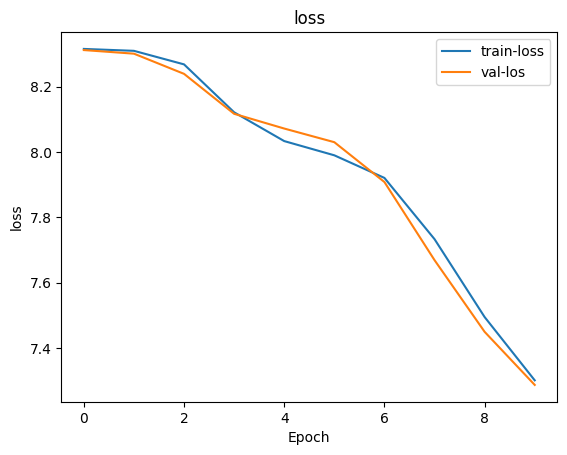

In [11]:
import matplotlib.pyplot as plt

def plot_performance(x, y1, y2, label_1, label_2, label_y):
    plt.plot(x, y1, label = label_1)
    plt.plot(x, y2, label = label_2)
    plt.xlabel('Epoch')
    plt.ylabel(label_y)
    plt.title(label_y)
    plt.legend()
    plt.show()


plot_performance(x=range(epoch),
                 y1=model.history.history['loss'],
                 y2=model.history.history['val_loss'],
                 label_1='train-loss',
                 label_2='val-los',
                 label_y='loss')

#### Looking at the recall of predicting the next song by epoch

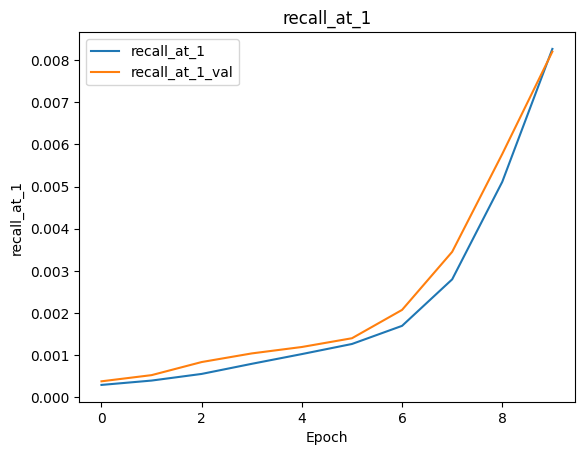

In [12]:
plot_performance(x=range(epoch),
                 y1=model.history.history['recall_at_1'],
                 y2=model.history.history['val_recall_at_1'],
                 label_1='recall_at_1',
                 label_2='recall_at_1_val',
                 label_y='recall_at_1')

#### Save the Query Model

In [13]:
query_tower = model.query_encoder

query_tower.save('query_model/')

/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(


In [14]:
from google.cloud import storage
import glob

import glob
import os 
from google.cloud import storage

GCS_CLIENT = storage.Client()
def upload_from_directory(directory_path: str, dest_bucket_name: str, dest_blob_name: str):
    rel_paths = glob.glob(directory_path + '/**', recursive=True)
    bucket = GCS_CLIENT.get_bucket(dest_bucket_name)
    for local_file in rel_paths:
        remote_path = f'{dest_blob_name}/{"/".join(local_file.split(os.sep)[1:])}'
        if os.path.isfile(local_file):
            blob = bucket.blob(remote_path)
            blob.upload_from_filename(local_file)

dest_blob = 'query_model_merlin'
upload_from_directory('query_model', BUCKET.replace('gs://',''), dest_blob)

In [15]:
output_workflow_dir

'gs://spotify-jsw-mpd-2023/workflow/2t-spotify-workflow'

### Save embeddings to GCS for each song - this will become our Matching Engine index

In [30]:
from merlin.models.utils.dataset import unique_rows_by_features

item_features = (
    unique_rows_by_features(train, Tags.ITEM, Tags.ID)
)

item_features_val = (
    unique_rows_by_features(valid, Tags.ITEM, Tags.ID)
)

In [31]:
item_embs = model.candidate_embeddings(
    item_features, index=item_features.schema['track_uri_can'], batch_size=10000
)

/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


In [32]:
item_embs_val = model.candidate_embeddings(
    item_features_val, index=item_features_val.schema['track_uri_can'], batch_size=10000
)

/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


In [33]:
# Quick look at the data
item_emb_pd = item_embs_val.compute().to_pandas()
item_emb_pd

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
track_uri_can,,,,,,,,,,,,,,,,,,,,,
0,0.156597,0.0,0.358118,1.253559,0.000000,0.563500,0.350794,0.000000,0.764257,0.000000,...,0.468885,0.812787,0.346340,0.000000,0.000000,0.0,0.832264,0.000000,1.049172,3.594275
1,0.036967,0.0,1.574395,0.000000,0.000000,1.719074,0.000000,0.000000,0.433207,1.295662,...,0.696981,0.000000,0.066725,0.000000,0.000000,0.0,0.526635,0.000000,1.764096,2.150635
2,0.173762,0.0,1.335858,0.000000,0.000000,1.981306,0.000000,0.000000,0.000000,2.701558,...,0.831433,0.000000,0.000000,0.077321,0.000000,0.0,0.580433,0.000000,1.358305,2.091223
3,0.155802,0.0,1.136039,0.296108,0.000000,1.328819,0.000000,0.000000,0.673788,0.458259,...,0.325813,0.000000,0.222266,0.000000,0.029706,0.0,0.534872,0.000000,1.343344,2.570790
4,0.032092,0.0,1.363372,0.000000,0.000000,1.906085,0.000000,0.000000,0.072069,1.709810,...,0.704574,0.000000,0.000000,0.000000,0.000000,0.0,0.764728,0.000000,1.710742,1.659744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178051,0.000000,0.0,0.300949,1.978246,0.165137,0.753515,0.000000,0.000000,0.669513,0.010681,...,0.351132,1.749218,0.451024,0.000000,0.000000,0.0,0.486183,0.062873,1.117377,2.645921
2178157,0.000000,0.0,0.217063,1.510675,1.545421,1.476855,0.051679,0.017275,1.573452,0.018097,...,0.327482,0.490127,0.106996,0.000000,0.000000,0.0,0.467018,0.000000,0.682899,0.944211
2178177,0.102678,0.0,0.464801,1.111067,0.000000,0.921787,0.091268,0.000000,0.768683,0.000000,...,0.269072,0.644362,0.640857,0.025221,0.000000,0.0,0.504872,0.074776,0.875016,3.188169


In [38]:
!rm candidate_embeddings.json > /dev/null
!touch candidate_embeddings.json

E0404 16:17:51.015818392    8113 backup_poller.cc:134]       Run client channel backup poller: {"created":"@1680625071.015672808","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1680625071.015669695","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":950,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
rm: cannot remove 'candidate_embeddings.json': No such file or directory


In [41]:
%%time

item_data = pd.read_parquet(os.path.join(BUCKET, "workflow/2t-spotify-workflow", 'categories/unique.track_uri_can.parquet'))

lookup_dict = dict(item_data['track_uri_can'])

def format_for_matching_engine(data) -> None:
    cols = [str(i) for i in range(layers[-1])] #ensure we are only pulling 0-EMBEDDING_DIM cols
    emb = [data[col] for col in cols]
    formatted_emb = '{"id":"' + str(data['track_uri_can']) + '","embedding":[' + ",".join(str(x) for x in list(emb)) + ']}'
    with open("candidate_embeddings.json", 'a') as f:
        f.write(formatted_emb)
        f.write("\n")
    f.close()

item_emb_pd = item_embs.compute().to_pandas().fillna(1e-10).reset_index() #filling blanks with an epsilon value
item_emb_pd['track_uri_can'] = item_emb_pd['track_uri_can'].apply(lambda l: lookup_dict[l])
_ = item_emb_pd.apply(format_for_matching_engine, axis=1)

item_emb_pd_val = item_embs_val.compute().to_pandas().fillna(1e-10).reset_index() #filling blanks with an epsilon value
item_emb_pd_val['track_uri_can'] = item_emb_pd_val['track_uri_can'].apply(lambda l: lookup_dict[l])
_ = item_emb_pd_val.apply(format_for_matching_engine, axis=1)


CPU times: user 26min 41s, sys: 2min 5s, total: 28min 47s
Wall time: 27min


In [42]:
!wc -l candidate_embeddings.json

2329097 candidate_embeddings.json


In [43]:
!mkdir embeddings
!mv candidate_embeddings.json embeddings
dest_blob = 'merlin-embeddings'
upload_from_directory('embeddings', BUCKET.replace('gs://',''), dest_blob)

## All set move to the next notebook - your bucket now should look something like this:

![](img/merlin-bucket.png)